In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.patheffects as path_effects
import math

# Step 1: Read `Zonal Histogram` and `Legend` CSV files

Two inputs are required:

1. **Zonal histogram**: calculated using the CORINE Landcover and the overlayed vector zones. This layer MUST include a `NAME` field, in addition to the calculated `HISTO_{BAND_NUM}` fields. All other fields are ignored
2. **Corine Landcover Legend (CLC Legend)**: This is a CSV that was included in the original data, and includes all the labels and associated color values. https://land.copernicus.eu/en/products/corine-land-cover, https://www.eea.europa.eu/data-and-maps/data/corine-land-cover-2/corine-land-cover-classes-and/clc_legend.csv

In [112]:
# Step 1: Load CSV files
zonal_histogram = pd.read_csv("data/zonal_histogram_bundeslander.csv") # Zonal Histogram Output
clc_legend = pd.read_csv("/home/ngavish/Projects/_DATA/CORINE/clc_legend.csv") # 

In [113]:
zonal_histogram.head()

,fid,NAME,HISTO_1,HISTO_2,HISTO_3,HISTO_4,HISTO_5,HISTO_6,HISTO_7,HISTO_8,...,HISTO_34,HISTO_35,HISTO_36,HISTO_37,HISTO_39,HISTO_40,HISTO_41,HISTO_42,HISTO_43,HISTO_44
0,1,Sachsen,3674,152459,29993,1402,48,2389,12227,1211,...,0,1012,297,0,0,2230,24988,0,0,0
1,2,Bayern,12496,354045,74342,3322,0,6370,8021,834,...,36,1893,13371,0,0,14043,51735,0,0,0
2,3,Rheinland-Pfalz,3779,126573,26572,1162,202,2908,4396,665,...,0,346,0,0,0,11551,3080,0,0,0
3,4,Saarland,932,36761,7491,486,36,145,683,522,...,0,162,0,0,0,172,484,0,0,0
4,5,Schleswig-Holstein,1636,97475,15745,355,590,2550,2698,489,...,0,3015,7153,6019,5018,4320,25341,4953,947,10851


In [114]:
clc_legend.head()

,GRID_CODE,CLC_CODE,LABEL1,LABEL2,LABEL3,RGB,Color,isNatural
0,1,111,Artificial surfaces,Urban fabric,Continuous urban fabric,230-000-077,NaN,0
1,2,112,Artificial surfaces,Urban fabric,Discontinuous urban fabric,255-000-000,NaN,0
2,3,121,Artificial surfaces,"Industrial, commercial and transport units",Industrial or commercial units,204-077-242,NaN,0
3,4,122,Artificial surfaces,"Industrial, commercial and transport units",Road and rail networks and associated land,204-000-000,NaN,0
4,5,123,Artificial surfaces,"Industrial, commercial and transport units",Port areas,230-204-204,NaN,0


# Step 2: Map the zonal histogram to the CLC legend labels

In [115]:
# Step 2: Reshape Zonal Histogram for easy access
histogram_columns = [col for col in zonal_histogram.columns if col.startswith("HISTO_")]

In [116]:
# Transpose and keep 'NAME' for context
zonal_histogram_long = zonal_histogram.melt(
    id_vars=["NAME"], value_vars=histogram_columns, var_name="HISTO", value_name="PixelCount")

In [117]:
# Extract the numeric part of HISTO (e.g., HISTO_1 -> 1)
zonal_histogram_long["GRID_CODE"] = zonal_histogram_long["HISTO"].str.extract(r"HISTO_(\d+)").astype(int)

In [118]:
# Merge with CLC Legend
zonal_histogram_long = zonal_histogram_long.merge(
    clc_legend[["GRID_CODE", "LABEL1", "LABEL2", "LABEL3"]],
    how="left", on="GRID_CODE"
)

In [119]:
zonal_histogram_long.head()

,NAME,HISTO,PixelCount,GRID_CODE,LABEL1,LABEL2,LABEL3
0,Sachsen,HISTO_1,3674,1,Artificial surfaces,Urban fabric,Continuous urban fabric
1,Bayern,HISTO_1,12496,1,Artificial surfaces,Urban fabric,Continuous urban fabric
2,Rheinland-Pfalz,HISTO_1,3779,1,Artificial surfaces,Urban fabric,Continuous urban fabric
3,Saarland,HISTO_1,932,1,Artificial surfaces,Urban fabric,Continuous urban fabric
4,Schleswig-Holstein,HISTO_1,1636,1,Artificial surfaces,Urban fabric,Continuous urban fabric


# Step 3: Select aggregation level (using label) to be used for analysis 

The CORINE dataset has generally three aggregation levels, ranging from `LABEL1 ` (most coarse) to `LABEL3` (most granular). Naturally, the level determines the number of landcover categories in the resulting plots. 

In [120]:
# Step 3: Select aggregation level (using label)
selected_label = "LABEL2"  # Change to LABEL2 or LABEL3 as needed
zonal_histogram_long["SelectedLabel"] = zonal_histogram_long[selected_label]

In [121]:
# Step 4: Aggregate Data
aggregated_data = zonal_histogram_long.groupby(["NAME", "SelectedLabel"], as_index=False).agg({"PixelCount": "sum"})

In [122]:
# Drop records where PixelCount is 0
aggregated_data = aggregated_data[aggregated_data["PixelCount"] > 0]

In [123]:
# Step 5: Ensure 'PixelPercentage' column exists
if "PixelPercentage" not in aggregated_data.columns:
    total_pixels_by_region = aggregated_data.groupby("NAME")["PixelCount"].transform("sum")
    aggregated_data["PixelPercentage"] = (aggregated_data["PixelCount"] / total_pixels_by_region) * 100

In [124]:
aggregated_data.head(20)

,NAME,SelectedLabel,PixelCount,PixelPercentage
0,Baden-Württemberg,Arable land,999898,27.680247
1,Baden-Württemberg,"Artificial, non-agricultural vegetated areas",15911,0.440465
2,Baden-Württemberg,Forests,1396155,38.649858
3,Baden-Württemberg,Heterogeneous agricultural areas,27358,0.757353
4,Baden-Württemberg,"Industrial, commercial and transport units",65574,1.815290
5,Baden-Württemberg,Inland waters,44296,1.226249
6,Baden-Württemberg,Inland wetlands,4876,0.134983
9,Baden-Württemberg,"Mine, dump and construction sites",5761,0.159482
11,Baden-Württemberg,Pastures,610403,16.897830
12,Baden-Württemberg,Permanent crops,139288,3.855920


# Plot Results as a Pie Chart (By Zone)

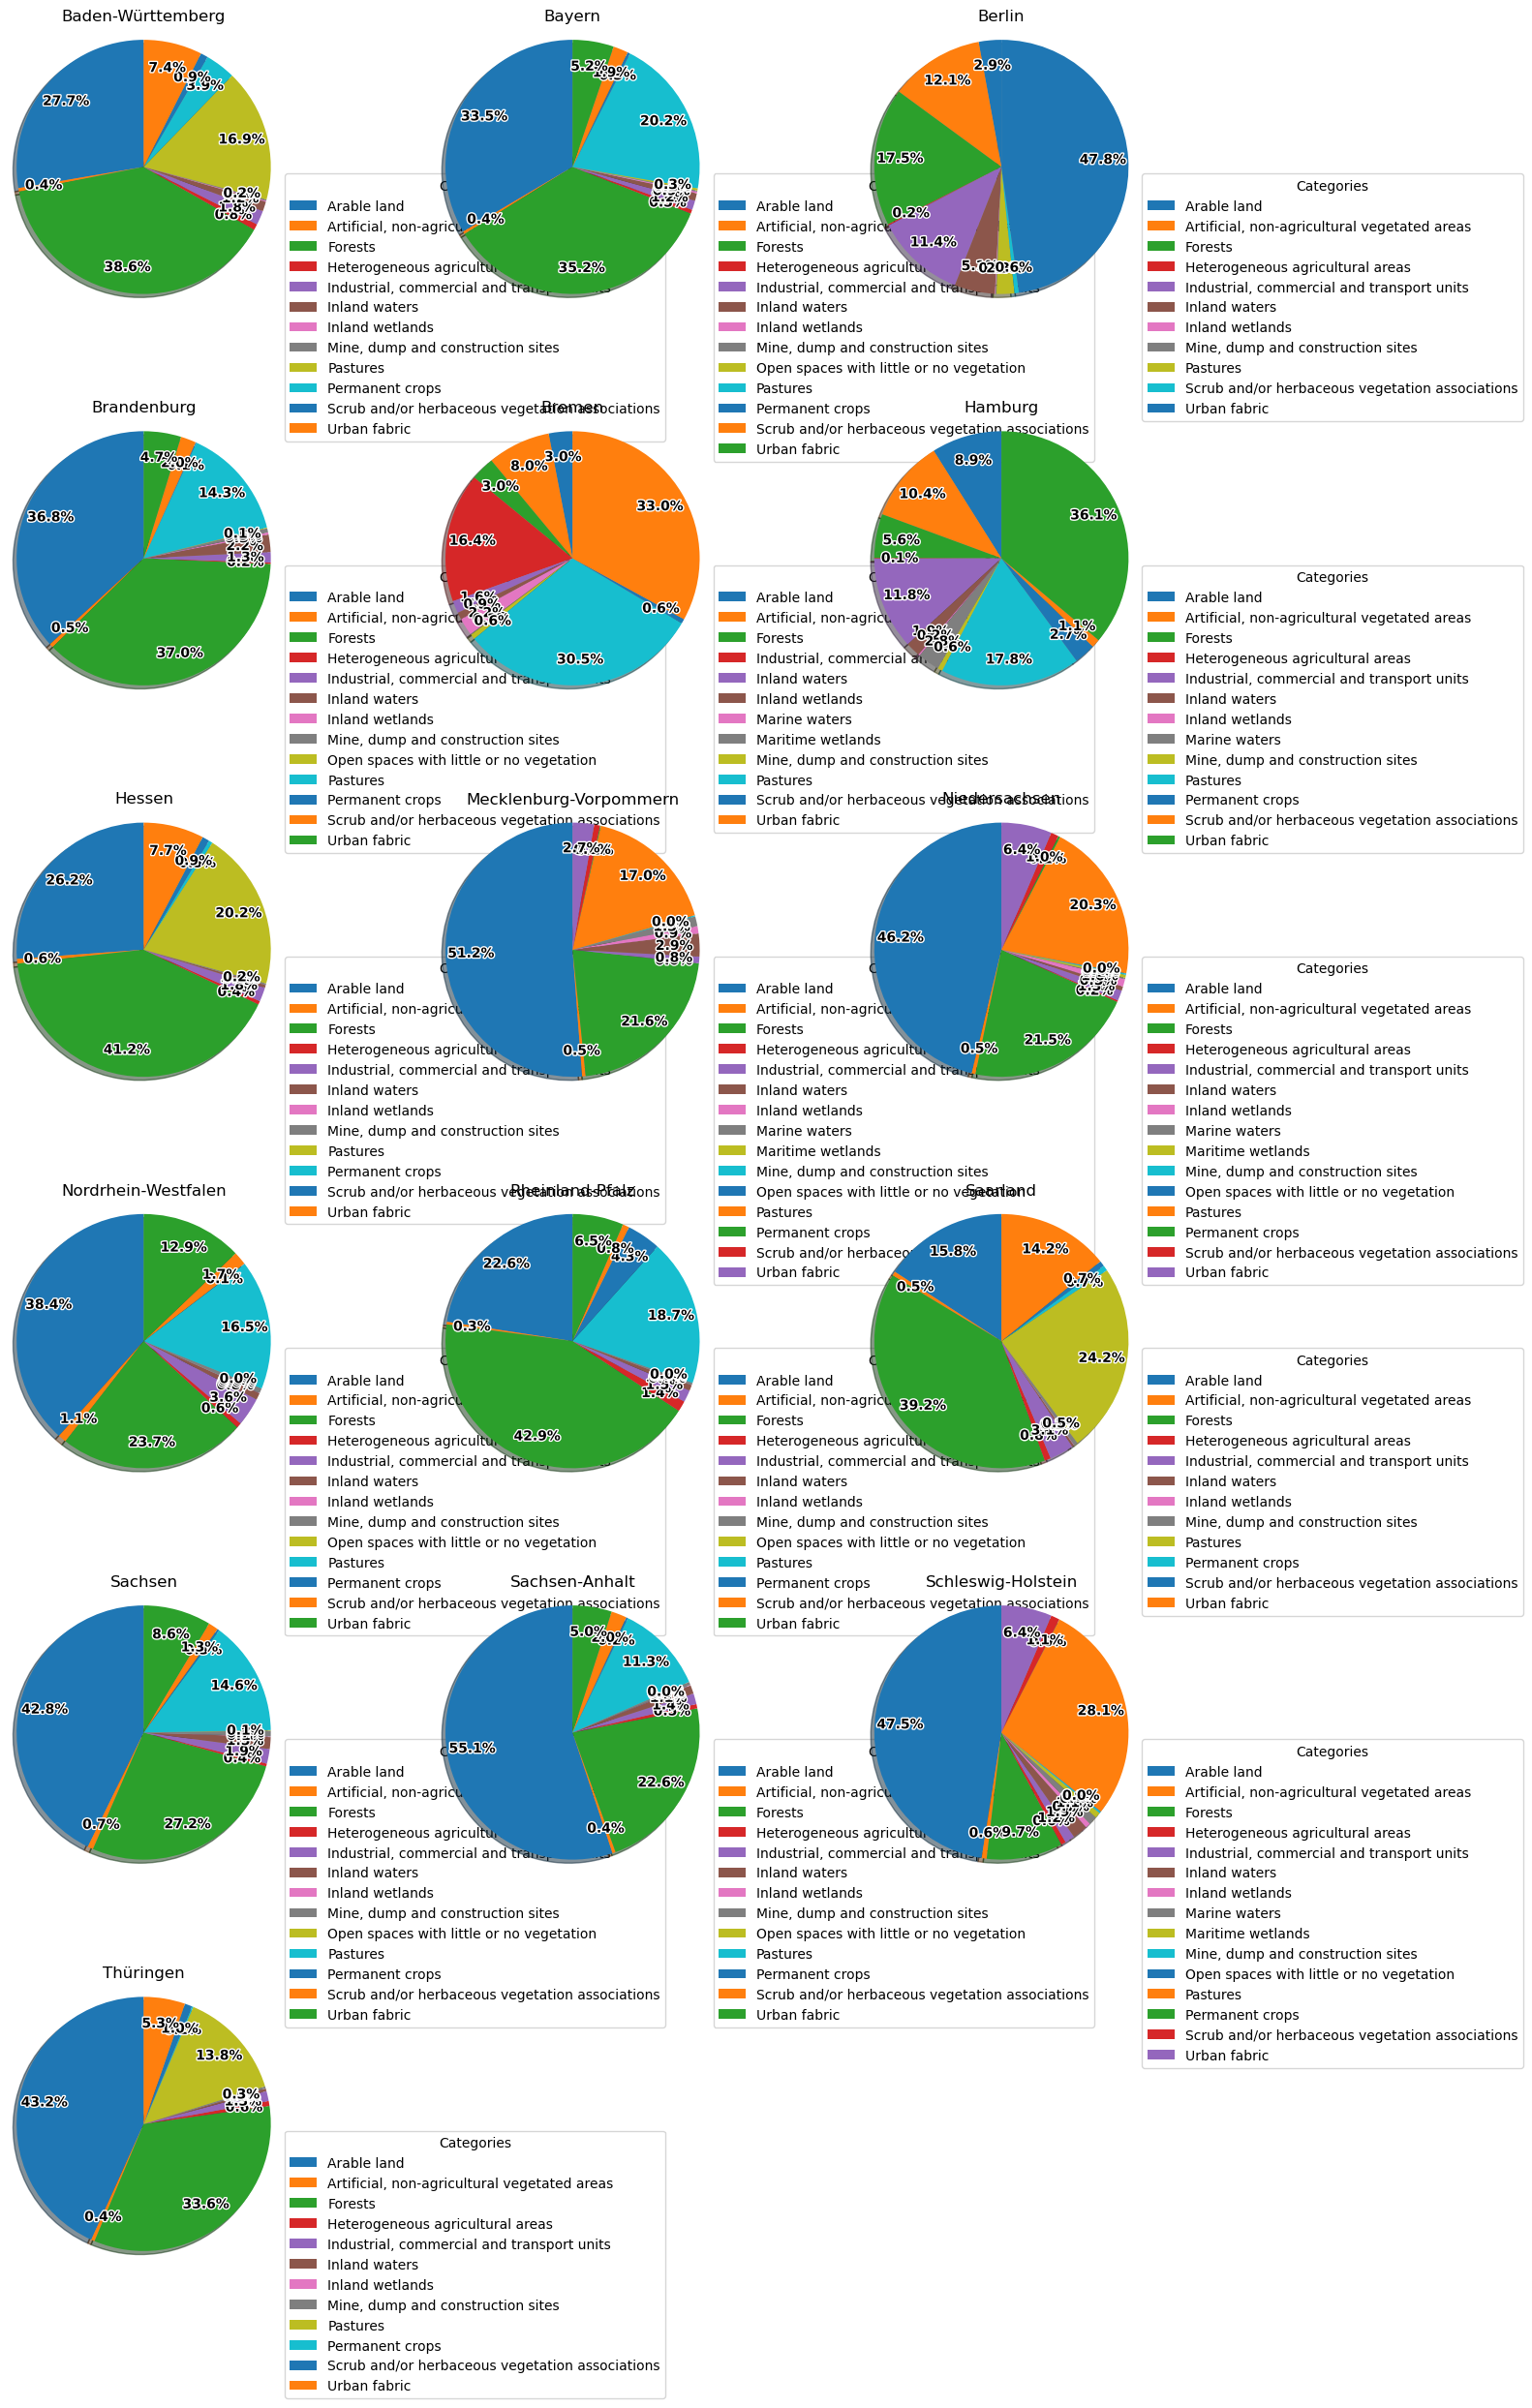

In [125]:
# Step 6: Plot Pie Charts (By Zone)
def plot_pie_charts(aggregated_data, unique_names):
    ncols = 3
    nrows = math.ceil(len(unique_names) / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
    axes = axes.flatten()

    for idx, name in enumerate(unique_names):
        plot_data = aggregated_data[aggregated_data["NAME"] == name]
        plot_data = plot_data.groupby("SelectedLabel")["PixelCount"].sum()

        wedges, _, autotexts = axes[idx].pie(
            plot_data, autopct='%1.1f%%', startangle=90, pctdistance=0.8, shadow=True
        )
        for autotext in autotexts:
            autotext.set_fontsize(10)
            autotext.set_weight('bold')
            autotext.set_color('black')
            autotext.set_path_effects([path_effects.withStroke(linewidth=2, foreground='white')])

        axes[idx].legend(
            wedges, plot_data.index, title="Categories", loc="upper left", bbox_to_anchor=(1, 0.5), fontsize=10
        )
        axes[idx].set_title(f"{name}", fontsize=12, pad=5)
        axes[idx].axis('equal')

    for idx in range(len(unique_names), len(axes)):
        fig.delaxes(axes[idx])

    plt.subplots_adjust(hspace=0.4, wspace=0.6)
    plt.savefig("output/combined_pie_charts.png", dpi=300, bbox_inches='tight')
    plt.show()

# Plot pie charts
unique_names = aggregated_data["NAME"].unique()
plot_pie_charts(aggregated_data, unique_names)

# Stacked Bar Chart (using Matplotlib); exact colors from CORINE Legend

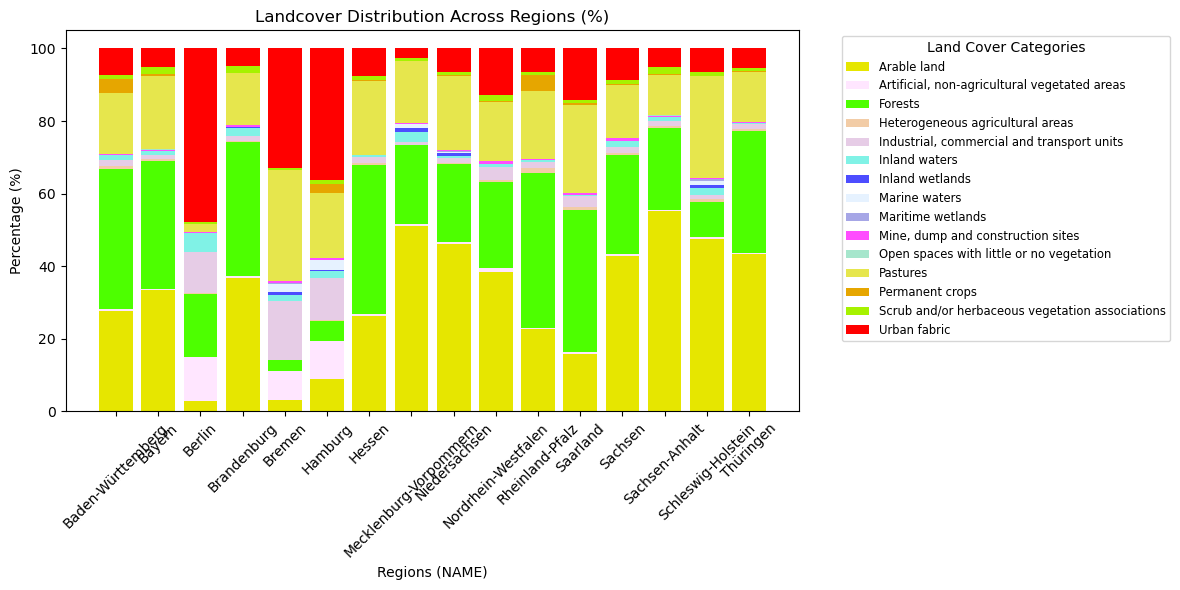

In [126]:
# Step 7: Plot Stacked Bar Chart (Matplotlib)
def plot_stacked_bar_chart(aggregated_data, clc_legend, selected_label):
    unique_labels = aggregated_data["SelectedLabel"].unique()
    filtered_legend = clc_legend[clc_legend[selected_label].isin(unique_labels)]

    def parse_rgb(rgb_str):
        return tuple(int(c) / 255.0 for c in rgb_str.split("-"))
    
    filtered_legend["RGB_Tuple"] = filtered_legend["RGB"].apply(parse_rgb)
    label_to_color = dict(zip(filtered_legend[selected_label], filtered_legend["RGB_Tuple"]))

    pivot_data_percentage = aggregated_data.pivot(
        index="NAME", columns="SelectedLabel", values="PixelPercentage"
    ).fillna(0)

    colors = [label_to_color[label] for label in pivot_data_percentage.columns]

    fig, ax = plt.subplots(figsize=(12, 6))
    bottoms = pd.Series([0] * len(pivot_data_percentage), index=pivot_data_percentage.index)

    for idx, col in enumerate(pivot_data_percentage.columns):
        ax.bar(
            pivot_data_percentage.index, pivot_data_percentage[col],
            label=col, bottom=bottoms, color=colors[idx]
        )
        bottoms += pivot_data_percentage[col]

    plt.ylabel("Percentage (%)")
    plt.xlabel("Regions (NAME)")
    plt.title("Landcover Distribution Across Regions (%)")
    plt.legend(title="Land Cover Categories", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.savefig("output/stacked_bar_chart.png", dpi=300)
    plt.show()

# Plot stacked bar chart
plot_stacked_bar_chart(aggregated_data, clc_legend, selected_label)

# Stacked Bar Chart (using Plotly)

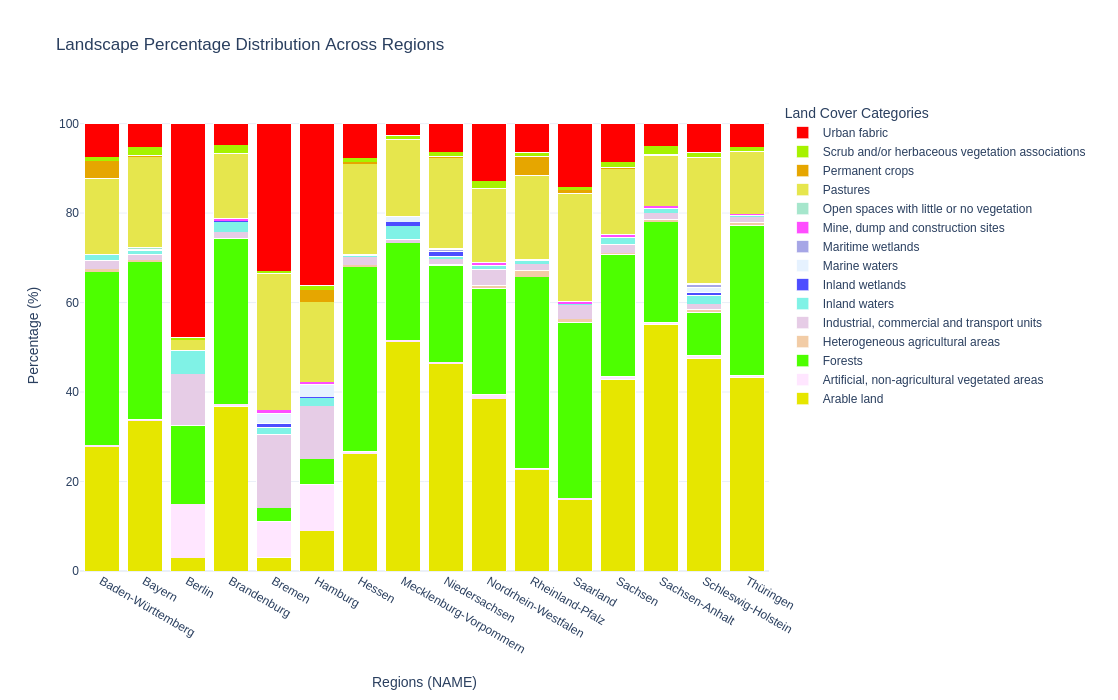

In [127]:
# Step 8: Plot Stacked Bar Chart (Plotly)
def plot_stacked_bar_chart_plotly(aggregated_data, clc_legend, selected_label):
    unique_labels = aggregated_data["SelectedLabel"].unique()
    filtered_legend = clc_legend[clc_legend[selected_label].isin(unique_labels)]

    def parse_rgb(rgb_str):
        return f"rgb({','.join(rgb_str.split('-'))})"

    filtered_legend["RGB_Tuple"] = filtered_legend["RGB"].apply(parse_rgb)
    label_to_color = dict(zip(filtered_legend[selected_label], filtered_legend["RGB_Tuple"]))

    pivot_data_percentage = aggregated_data.pivot(
        index="NAME", columns="SelectedLabel", values="PixelPercentage"
    ).fillna(0)

    fig = go.Figure()

    for label in pivot_data_percentage.columns:
        fig.add_trace(go.Bar(
            x=pivot_data_percentage.index, y=pivot_data_percentage[label],
            name=label, marker_color=label_to_color[label],
            hovertemplate="%{y:.2f}%",  # Format hover label with 1 decimal place and percentage sign
        ))

    fig.update_layout(
        height=700, width=1000, barmode='stack', title="Landscape Percentage Distribution Across Regions",
        xaxis_title="Regions (NAME)", yaxis_title="Percentage (%)", legend_title="Land Cover Categories",
        hovermode="x unified", template="plotly_white"
    )

    fig.show()

# Plot stacked bar chart (Plotly)
plot_stacked_bar_chart_plotly(aggregated_data, clc_legend, selected_label)